In [9]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import numpy as np

from SES_setup import *
from utils import *
from style import *

plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rc('grid', linestyle="--", color='grey')
plt.rcParams['grid.linestyle'] = "--"
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.3
plt.rcParams['lines.linewidth'] = 2.3
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']


colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]
colors+=colours

In [2]:
w_2 = 1. * ev_to_inv_cm
bias = 0. # 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 10e-3 * ev_to_inv_cm
T_EM = 300.
T_ph = 300.
Gamma_EM = 7e-7*ev_to_inv_cm # 1ns
#alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
wc = eta
w0 = 6*eta # 18e-3*ev_to_inv_cm
Gamma = (w0**2)/wc
print(eta, w0, Gamma, Occupation(w0, T_ph))
N=5


PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=5)

(161.31, 967.86, 5807.160000000001, 0.009732063035413449)


In [3]:

def displace(offset, a):
    return (offset*(a.dag())/sqrt(2) - offset.conjugate()*a/sqrt(2)).expm()

def undisplaced_initial(init_sys, PARAMS):
    n1 = Occupation(PARAMS['w0_1'], PARAMS['T_1'])
    n2 = Occupation(PARAMS['w0_2'], PARAMS['T_2'])
    return tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], 
                                              [n1, n2]))
def position_ops(PARAMS):
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    return [tensor(I_sys, (a + a.dag())/sqrt(2)) for a, omega in zip(atemp, [PARAMS['w0_1'], PARAMS['w0_2']])]


def offsets(init_sys, PARAMS):
    energies, states = exciton_states(PARAMS)
    normal_disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    normal_disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']+4*PARAMS['V'])
    coeff_p = (eta + PARAMS['bias'])/(2*eta)
    coeff_m = (eta - PARAMS['bias'])/(2*eta)
    if init_sys == 'dark':
        return states[0], normal_disp_1*coeff_m, normal_disp_2*coeff_p
    elif init_sys == 'bright':
        return states[1], normal_disp_1*coeff_p, normal_disp_2*coeff_m
    elif init_sys == 'ground':
        return OO, 0, 0
    else:
        raise KeyError("Please choose dark, bright or ground")

def displaced_initial(PARAMS, init_sys='dark', silent=False, return_error=False):
    init_state, offset_1, offset_2 = offsets(init_sys, PARAMS)
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    x = position_ops(PARAMS)
    r0 = undisplaced_initial(init_state*init_state.dag(), PARAMS)
    disp = copy.deepcopy(r0)
    for offset, a_ in zip([offset_1, offset_2], atemp):
        d = tensor(I_sys, displace(offset, a_))
        disp =  d * disp * d.dag()
    try:
        error = 100*(abs((disp*x[0]).tr()- offset_1)/offset_1 + abs((disp*x[1]).tr()- offset_2)/offset_2)
        if error>0.5:
            print ("Error in displacement: {:0.8f}%. Predicted {:0.4f} , actual {:0.4f}".format(error, offset_1, (disp*x[0]).tr()))
            print ("Ratio of kBT to Omega: {:0.4f}".format(0.695*PARAMS['T_1']/PARAMS['w0_1']))
            if ((PARAMS['T_1'] != PARAMS['T_2']) or (PARAMS['w0_1'] != PARAMS['w0_2'])):
               print("Ratio of kBT to Omega (2): {:0.4f}".format(0.695*PARAMS['T_2']/PARAMS['w0_2']))
        if return_error:   
            return disp, error
        else:
            return disp
    except:
        return disp


In [51]:
dynamics_list1 = []
alpha_list = [1e-3, 5e-3, 20e-3]

for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(0, 1/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    #rho_0 = states_dict['bright'][3]*states_dict['bright'][3].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    for nsteps in np.linspace(1000, 5000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_list1.append(dynamics)
            break
        except Exception as e:
            print("failed... because {}".format(e))
            

****************************************************************
The operators took 5.1208190918 and have dimension 75.
Building the RC Liouvillian took 5.825 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 3.21827602386 seconds.
Full optical Liouvillian took 1.20649194717 seconds.
Chopping reduced the sparsity from 4.966% to 4.966%
could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
(8.0655, 10)
1000.0
10.0%. Run time:   9.93s. Est. time left: 00:00:01:29
20.0%. Run time:  21.51s. Est. time left: 00:00:01:26
30.0%. Run time:  32.18s. Est. time left: 00:00:01:15
40.0%. Run time:  41.67s. Est. time left: 00:00:01:02
50.0%. Run time:  51.12s. Est. time left: 00:00:00:51
60.0%. Run time:  60.55s. Est. time left: 00:00:00:40
70.0%. Run time:  70.23s. Est. time left: 00:00:00:30
80.0%. Run time

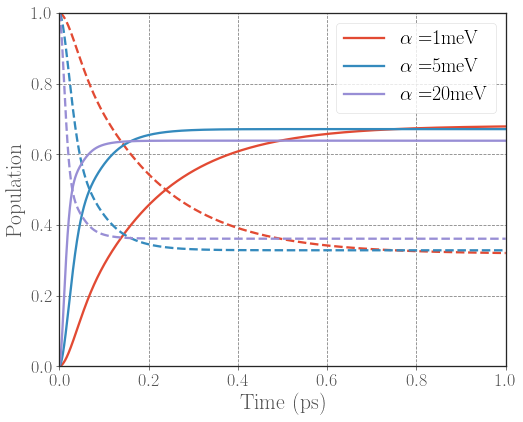

In [144]:
plt.figure(figsize=(8,6.5))
alpha_list = [1 , 5, 20]
for i, dynamics in enumerate(dynamics_list1[0:3]):
    l = r"$\alpha=$"+"{}meV".format(alpha_list)
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[0], color=colors[i], 
             label=r"$\alpha=$"+"{}meV".format(alpha_list[i]))
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[1], color=colors[i], ls="dashed")

plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel("Population")
plt.xlabel("Time (ps)")
plt.legend()
plt.savefig("PLOTS/PAPER/dynamics_1.pdf")

In [53]:
dynamics_list2 = []
alpha_list = [1e-3, 5e-3, 20e-3]

for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(0, 1/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    #rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    rho_0 = states_dict['bright'][3]*states_dict['bright'][3].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    for nsteps in np.linspace(1000, 5000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_list1.append(dynamics)
            break
        except Exception as e:
            print("failed... because {}".format(e))

****************************************************************
The operators took 4.69381904602 and have dimension 75.
Building the RC Liouvillian took 5.383 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 2.89857697487 seconds.
Full optical Liouvillian took 1.09299683571 seconds.
Chopping reduced the sparsity from 4.966% to 4.966%
could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
(8.0655, 10)
1000.0
10.0%. Run time:  11.41s. Est. time left: 00:00:01:42
20.0%. Run time:  21.81s. Est. time left: 00:00:01:27
30.0%. Run time:  33.47s. Est. time left: 00:00:01:18
40.0%. Run time:  43.72s. Est. time left: 00:00:01:05
50.0%. Run time:  53.10s. Est. time left: 00:00:00:53
60.0%. Run time:  62.43s. Est. time left: 00:00:00:41
70.0%. Run time:  71.60s. Est. time left: 00:00:00:30
80.0%. Run tim

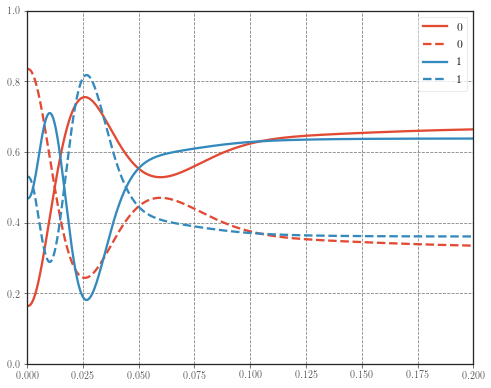

In [66]:
plt.figure(figsize=(8,6.5))
for i, dynamics in enumerate(dynamics_list1[4::]):
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[0], color=colors[i], label=i)
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[1], color=colors[i], ls="dashed", label=i)

plt.xlim(0,0.2)
plt.ylim(0,1)
plt.legend()


In [68]:
dynamics_list2 = []
alpha_list = [1e-3, 5e-3, 20e-3]

for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(0, 1/inv_ps_to_inv_cm, 6000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    #rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    rho_0 = states_dict['bright'][1]*states_dict['bright'][1].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    for nsteps in np.linspace(1000, 5000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_list2.append(dynamics)
            break
        except Exception as e:
            print("failed... because {}".format(e))

****************************************************************
The operators took 5.11890101433 and have dimension 75.
Building the RC Liouvillian took 5.818 seconds.
It is 5625by5625. The full basis would be 5625by5625
Full optical Liouvillian took 2.75110507011 seconds.
Full optical Liouvillian took 1.19549298286 seconds.
Chopping reduced the sparsity from 4.966% to 4.966%
could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
(8.0655, 10)
1000.0
10.0%. Run time:  17.82s. Est. time left: 00:00:02:40
20.0%. Run time:  34.58s. Est. time left: 00:00:02:18
30.0%. Run time:  51.25s. Est. time left: 00:00:01:59
40.0%. Run time:  67.86s. Est. time left: 00:00:01:41
50.0%. Run time:  84.59s. Est. time left: 00:00:01:24
60.0%. Run time: 101.23s. Est. time left: 00:00:01:07
70.0%. Run time: 119.10s. Est. time left: 00:00:00:51
80.0%. Run tim

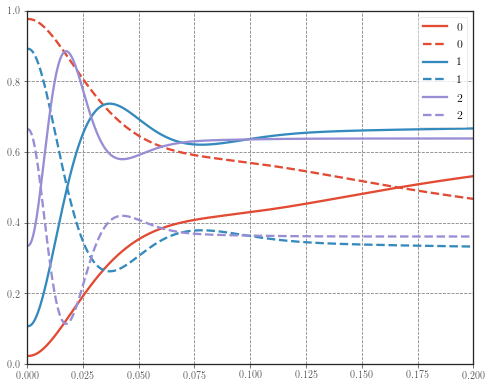

In [69]:
plt.figure(figsize=(8,6.5))
for i, dynamics in enumerate(dynamics_list2):
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[0], color=colors[i], label=i)
    plt.plot(timelist*inv_ps_to_inv_cm, dynamics.expect[1], color=colors[i], ls="dashed", label=i)

plt.xlim(0,0.2)
plt.ylim(0,1)
plt.legend()

In [136]:
1/0.0375, 1/0.075

(26.666666666666668, 13.333333333333334)

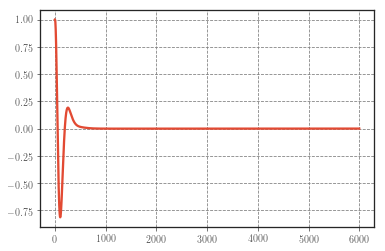

In [127]:
dyn_dat = dynamics_list2[2].expect[0] - dynamics_list2[2].expect[0][-1]
dyn_dat/=dyn_dat[0]
plt.plot(dyn_dat)

In [128]:
spec = sp.fftpack.fft(dyn_dat)
dt = (timelist[1]-timelist[0])
freq = 2 * pi * np.array(sp.fftpack.fftfreq(spec.size, dt))
spec = 2 * dt* np.real(spec)
spec-= min(spec)
spec = spec/sum(spec)
freq, spec = zip(*sorted(zip(freq, np.array(spec).real)))

In [116]:
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) #

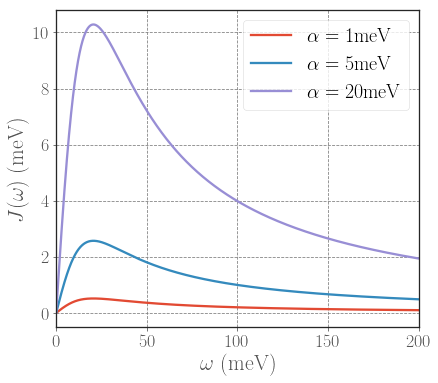

In [51]:
def plot_UD_SD_PARAMS(PARAMS, ax=None):
    eps = gap(PARAMS['bias'], PARAMS['V'])*10
    alpha = PARAMS['alpha_2']
    w_0 = PARAMS['w0_2']
    Omega = np.linspace(0.,eps,10000)
    J_w = np.array([J_underdamped(w, alpha, w_0, Gamma=Gamma) for w in Omega])
    show_im = ax
    if ax is None:
        f, ax = plt.subplots(1,1)
    ax.plot(1000*Omega/ev_to_inv_cm, 1000*J_w/ev_to_inv_cm, 
            label=r"$\alpha=$ {}meV".format(int(1000*PARAMS['alpha_2']/ev_to_inv_cm)))
    ax.set_xlabel(r"$\omega$ (meV)")
    ax.set_ylabel(r"$J(\omega)$ (meV)")
    #if show_im is None:
    #    plt.show()
    ax.legend()
f, ax = plt.subplots(1,1, figsize=(6.5,5.1))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.989, wspace=0., hspace=0.02)
PARAMS['alpha_2'] = 1e-3*ev_to_inv_cm
plot_UD_SD_PARAMS(PARAMS, ax=ax)
PARAMS['alpha_2'] = 5e-3*ev_to_inv_cm
plot_UD_SD_PARAMS(PARAMS, ax=ax)
PARAMS['alpha_2'] = 20e-3*ev_to_inv_cm
plot_UD_SD_PARAMS(PARAMS, ax=ax)
ax.set_xlim(0,200)
plt.savefig("PLOTS/PAPER/overdampedSDs.pdf")

# Long time dynamics

In [4]:
dynamics_list_lt = []
alpha_list = [1e-3, 5e-3, 20e-3]
N=4
for i, alpha in enumerate(alpha_list):
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha*ev_to_inv_cm,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=Gamma_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
    H, L, PARAMS = get_H_and_L(PARAMS,silent=False, threshold=0)
    ops = make_expectation_operators(PARAMS)
    print("could calculate:")
    print(ops.keys())
    timelist = np.linspace(1/inv_ps_to_inv_cm, 6000/inv_ps_to_inv_cm, 24000)  # List of time values for dynamics 
    print(PARAMS['alpha_1'], PARAMS['exc'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8) # 
    rho_0 = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
    #rho_0 = steadystate(H[1], [L['nonadd']])
    #rho_0 = states_dict['bright'][1]*states_dict['bright'][1].dag() # Start system in ground vibrational state
    e_ops = [ops['dark'], ops['bright'], ops['OO']]             # List of expectation values to calculate
    for nsteps in np.linspace(1000, 15000, 5):
        try:
            print(nsteps)
            options = qt.Options(nsteps=int(nsteps))
            dynamics = qt.mesolve(H[1], rho_0, timelist, c_ops=[L['nonadd']], e_ops=e_ops, 
                                  progress_bar=True, options=options)
            dynamics_list2.append(dynamics)
            break
        except Exception as e:
            print("failed... because {}".format(e))

****************************************************************
The operators took 1.75271606445 and have dimension 48.
Building the RC Liouvillian took 1.926 seconds.
It is 2304by2304. The full basis would be 2304by2304
Full optical Liouvillian took 1.17902398109 seconds.
Full optical Liouvillian took 0.517604112625 seconds.
Chopping reduced the sparsity from 7.357% to 7.357%
could calculate:
['OO', 'sigma_z', 'sigma_y', 'sigma_x', 'XO', 'RC2_number', 'eig_x_equiv', 'dark', 'bright', 'RC1_number', 'RC2_position', 'OX', 'site_coherence', 'RC1_position1', 'eig_y', 'eig_x', 'eig_z']
(8.0655, 8)
1000.0


/Users/henrymaguire/.pyenv/versions/2.7.15/lib/python2.7/site-packages/scipy/integrate/_ode.py:1009: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


failed... because ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.
4500.0
failed... because ODE integration error: Try to increase the allowed number of substeps by increasing the nsteps parameter in the Options class.
8000.0



KeyboardInterrupt

